In [1]:
import re
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from time import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu

In [2]:
dataset_path = 'C:/Users/nandi/Downloads/flickr'
dataset_images_path = dataset_path + "/Images/" 

In [3]:
img_height = 180
img_width = 180
validation_split = 0.2

In [4]:
def get_encoder():
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output

    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    return image_features_extract_model

In [5]:
def get_preprocessed_caption(caption):    
    caption = re.sub(r'\s+', ' ', caption)
    caption = caption.strip()
    caption = "<start> " + caption + " <end>"
    return caption

In [6]:
images_captions_dict = {}

with open(dataset_path + "/captions.txt", "r") as dataset_info:
    next(dataset_info)
    for info_raw in list(dataset_info)[:10000]:+
        info = info_raw.split(",")
        image_filename = info[0]
        caption = get_preprocessed_caption(info[1])

        if image_filename not in images_captions_dict.keys():
            images_captions_dict[image_filename] = [caption]
        else:
            images_captions_dict[image_filename].append(caption)
images_captions_dict

{'1000268201_693b08cb0e.jpg': ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
  '<start> A girl going into a wooden building . <end>',
  '<start> A little girl climbing into a wooden playhouse . <end>',
  '<start> A little girl climbing the stairs to her playhouse . <end>',
  '<start> A little girl in a pink dress going into a wooden cabin . <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> A black dog and a spotted dog are fighting <end>',
  '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
  '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
  '<start> Two dogs of different breeds looking at each other on the road . <end>',
  '<start> Two dogs on pavement moving toward each other . <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
  '<start> A little gir

In [7]:
def load_image(image_path):
    img = tf.io.read_file(dataset_images_path + image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [8]:
image_captions_dict_keys = list(images_captions_dict.keys())
image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [9]:
images_dict = {}
encoder = get_encoder()
for img_tensor, path_tensor in tqdm(image_dataset):
    batch_features_tensor = encoder(img_tensor)
    for batch_features, path in zip(batch_features_tensor, path_tensor):
        decoded_path = path.numpy().decode("utf-8")
        images_dict[decoded_path] = batch_features.numpy()

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.29s/it]


In [10]:
list(images_dict.items())[0][1].shape

(4, 4, 2048)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


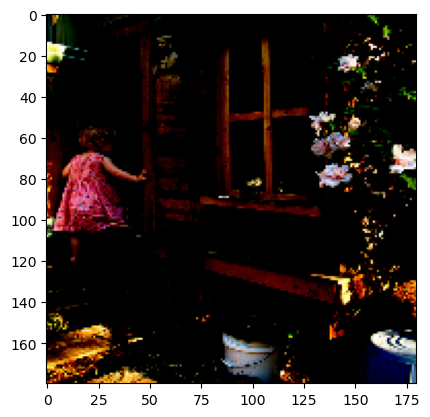

In [11]:
plt.imshow(load_image('1000268201_693b08cb0e.jpg')[0].numpy())

In [12]:
def get_images_labels(image_filenames):
    images = []
    labels = []
    
    for image_filename in image_filenames:
        image = images_dict[image_filename]
        captions = images_captions_dict[image_filename]
        for caption in captions:
            images.append(image)
            labels.append(caption)
            
    return images, labels

In [13]:
image_filenames = list(images_captions_dict.keys())
image_filenames_train, image_filenames_test = \
    train_test_split(image_filenames, test_size=validation_split, random_state=1)

X_train, y_train_raw = get_images_labels(image_filenames_train)
X_test, y_test_raw = get_images_labels(image_filenames_test)

In [14]:
len(X_train), len(y_train_raw), len(X_test), len(y_test_raw)

(3200, 3200, 800, 800)

In [15]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(y_train_raw)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
y_train = tokenizer.texts_to_sequences(y_train_raw)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post')

In [16]:
max_caption_length = max(len(t) for t in y_train)
print(max_caption_length)

35


In [17]:
[tokenizer.index_word[i] for i in y_train[1]]

['<start>',
 'a',
 'black',
 'dog',
 'is',
 'standing',
 'on',
 'a',
 'step',
 'next',
 'to',
 'a',
 'river',
 'at',
 'it',
 'shakes',
 'itself',
 'dry',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [19]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
NUM_STEPS = BUFFER_SIZE // BATCH_SIZE
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [20]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [21]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size) #, activation='softmax') 
    def call(self, captions, features, omit_features = False, initial_state = None, verbose = False):
        if verbose:
            print("Before embedding")
            print(captions.shape)

        embed = self.embedding(captions)

        if verbose:
            print("Embed")
            print(embed.shape)

        features = tf.expand_dims(features, 1)
        
        if verbose:
            print("Features")
            print(features.shape)
        lstm_input = tf.concat([features, embed], axis=-2) if (omit_features == False) else embed
        
        if verbose:
            print("LSTM input")
            print(lstm_input.shape)
        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state)

        if verbose:
            print("LSTM output")
            print(output.shape)
        output = self.fc(output)

        return output, memory_state, carry_state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [22]:
units = embedding_dim = 512
vocab_size = min(top_k + 1, len(tokenizer.word_index.keys()))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred, verbose=False):
    loss_ = loss_object(real, pred)
    
    if verbose:
        print("Loss")
        print(loss_)
    
    loss_ = tf.reduce_mean(loss_, axis = 1)
        
    if verbose:
        print("After Mean Axis 1")    
        print(loss_)

    return loss_

In [23]:
@tf.function
def train_step(img_tensor, target, verbose=False):    
    if verbose:
        print("Image tensor")
        print(img_tensor.shape)

        print("Target")
        print(target.shape)    

    dec_input = tf.convert_to_tensor(target[:, :-1])
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        if verbose:
            print("Features CNN")
            print(features)
            
        predictions, _, _ = decoder(dec_input, features, verbose=verbose)        
        
        if verbose:
            print("Predictions RNN")
            print(predictions)
        
        caption_loss = loss_function(target, predictions)
        total_batch_loss = tf.reduce_sum(caption_loss)
        mean_batch_loss = tf.reduce_mean(caption_loss)
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(caption_loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_batch_loss, mean_batch_loss

In [24]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [36]:
loss_plot = []

In [37]:
EPOCHS = 30
start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    real_epoch = len(loss_plot) + 1
    start = time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=False)
        total_loss += total_batch_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Batch Loss {:.4f}'.format(real_epoch, batch, mean_batch_loss.numpy()))
    
    print ('Total Loss {:.6f}'.format(total_loss))
    epoch_loss = total_loss / NUM_STEPS
    loss_plot.append(epoch_loss)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))

Epoch 1 Batch 0 Batch Loss 0.1645
Total Loss 545.368286
Epoch 1 Epoch Loss 10.907366
Time taken for 1 epoch 33.161224126815796 sec

Epoch 2 Batch 0 Batch Loss 0.1672
Total Loss 535.786377
Epoch 2 Epoch Loss 10.715728
Time taken for 1 epoch 29.568480730056763 sec

Epoch 3 Batch 0 Batch Loss 0.1536
Total Loss 536.562561
Epoch 3 Epoch Loss 10.731251
Time taken for 1 epoch 29.532008171081543 sec

Epoch 4 Batch 0 Batch Loss 0.1642
Total Loss 556.187439
Epoch 4 Epoch Loss 11.123749
Time taken for 1 epoch 29.58731460571289 sec

Epoch 5 Batch 0 Batch Loss 0.1618
Total Loss 541.552979
Epoch 5 Epoch Loss 10.831059
Time taken for 1 epoch 29.807970762252808 sec

Epoch 6 Batch 0 Batch Loss 0.1520
Total Loss 524.201050
Epoch 6 Epoch Loss 10.484021
Time taken for 1 epoch 33.34869122505188 sec

Epoch 7 Batch 0 Batch Loss 0.1551
Total Loss 527.382812
Epoch 7 Epoch Loss 10.547656
Time taken for 1 epoch 29.538341999053955 sec

Epoch 8 Batch 0 Batch Loss 0.1587
Total Loss 538.588806
Epoch 8 Epoch Loss 10.

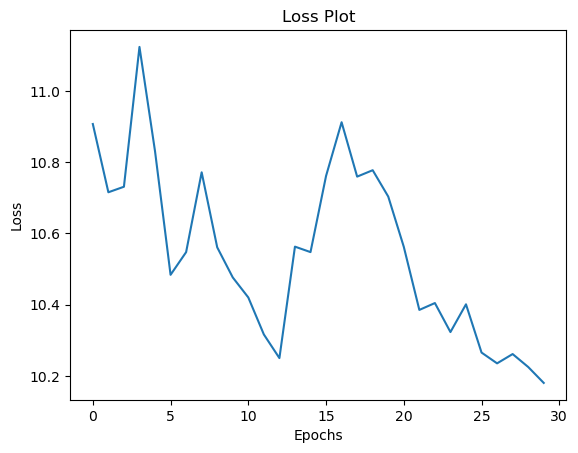

In [38]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [39]:
def clean_caption(caption):
    return [item for item in caption if item not in ['<start>', '<end>', '<pad>']]

In [40]:
def get_caption(img):   
    features = encoder(tf.expand_dims(img, 0))
    caption = []
    dec_input = tf.expand_dims([], 0)
    
    state = None
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    caption1 = clean_caption(caption)
    str1 = " "
    return (str1.join(caption1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


133189853_811de6ab2a.jpg


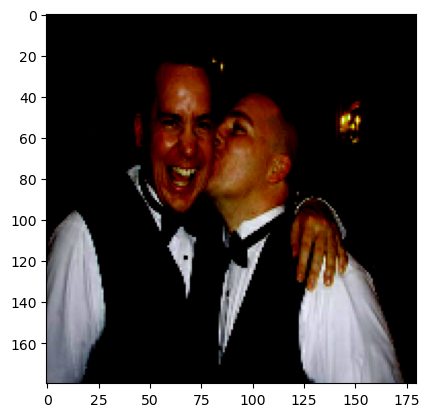

In [41]:
test_img_name = random.choice(image_filenames_train)
print(test_img_name)
plt.imshow(load_image(test_img_name)[0].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a man in a black jacket is taking a photo of a man in a red jacket


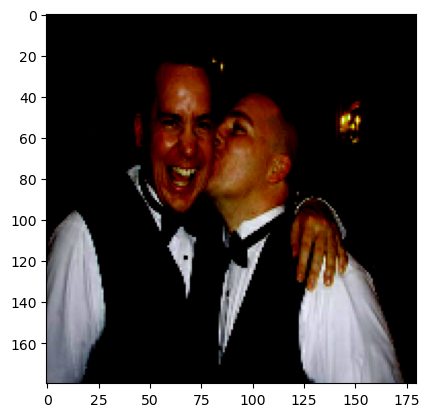

In [42]:
print(get_caption(images_dict[test_img_name]))
plt.imshow(load_image(test_img_name)[0].numpy())

In [43]:
actual, predicted = [], []

for test_img_name in image_filenames_test:
    img = images_dict[test_img_name]
    estimated_caption = get_caption(img).split()

    captions = [clean_caption(caption.split()) for caption in images_captions_dict[test_img_name]]
    
    actual.append(captions)
    predicted.append(estimated_caption)

print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.346062
BLEU-2: 0.168099


In [44]:
import tensorflow as tf
import gradio as gr

def load_imagegrad(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

def generate_caption(image):
    if isinstance(image, str): 
        image_path = image
    elif isinstance(image, np.ndarray):
        image_path = "image.jpg" 
        tf.keras.preprocessing.image.save_img(image_path, image)
    else:
        raise ValueError("Unsupported image type.")

    img, _ = load_imagegrad(image_path)
    cnn_encoder = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")
    img = tf.expand_dims(img, axis=0)
    img = cnn_encoder(img)
    img = tf.keras.layers.Flatten()(img)
    caption = get_caption(img)

    return caption

inputs = gr.inputs.Image(label="Input Image")
outputs = gr.outputs.Textbox(label="Generated Caption")

title = "CaptionNet"
description = "The image given can best described as"

gr.Interface(fn=generate_caption, inputs=inputs, outputs=outputs, title=title, description=description).launch()


C:\Users\nandi\anaconda3\lib\site-packages\gradio\inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\nandi\anaconda3\lib\site-packages\gradio\inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
C:\Users\nandi\anaconda3\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
